In [1]:
# Build list of forecast file names for a date range and a specific time (HHMM) 
import os, re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER INPUTS ---
start_date = "2025-09-01"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
end_date   = "2025-09-30"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
time_str   = "1100"         # 'HHMM' e.g. '0100', '0115', '2300'

# --- Build list ---
# Normalize dates with pandas
start = pd.to_datetime(start_date)
end = pd.to_datetime(end_date)

# Validate the time format
if not (isinstance(time_str, str) and len(time_str) == 4 and time_str.isdigit()):
    raise ValueError("time_str must be a string in 'HHMM' format, e.g. '0100' or '1115'.")

# Generate daily dates (inclusive)
dates = pd.date_range(start=start, end=end, freq="D")

# Create file names
names = [f"forecast_{d.strftime('%Y%m%d')}{time_str}.csv" for d in dates]

file_list_df = pd.DataFrame({"filename": names})

# Show results
print(names)           # Python list
file_list_df           # Pandas DataFrame view


['forecast_202509011100.csv', 'forecast_202509021100.csv', 'forecast_202509031100.csv', 'forecast_202509041100.csv', 'forecast_202509051100.csv', 'forecast_202509061100.csv', 'forecast_202509071100.csv', 'forecast_202509081100.csv', 'forecast_202509091100.csv', 'forecast_202509101100.csv', 'forecast_202509111100.csv', 'forecast_202509121100.csv', 'forecast_202509131100.csv', 'forecast_202509141100.csv', 'forecast_202509151100.csv', 'forecast_202509161100.csv', 'forecast_202509171100.csv', 'forecast_202509181100.csv', 'forecast_202509191100.csv', 'forecast_202509201100.csv', 'forecast_202509211100.csv', 'forecast_202509221100.csv', 'forecast_202509231100.csv', 'forecast_202509241100.csv', 'forecast_202509251100.csv', 'forecast_202509261100.csv', 'forecast_202509271100.csv', 'forecast_202509281100.csv', 'forecast_202509291100.csv', 'forecast_202509301100.csv']


,filename
0,forecast_202509011100.csv
1,forecast_202509021100.csv
2,forecast_202509031100.csv
3,forecast_202509041100.csv
4,forecast_202509051100.csv
5,forecast_202509061100.csv
6,forecast_202509071100.csv
7,forecast_202509081100.csv
8,forecast_202509091100.csv
9,forecast_202509101100.csv


In [10]:
# ===================== PATHS =====================
ACTUALS_CSV = "/home/renga/Desktop/neoen_data/renga_work/data/measurements_neoen_morcenx_sep2025.csv"      # actuals (kW @ 15-min)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"             # has measure_date, da_price, Long, Short
FC_DIR      = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")                     # forecast directory

GRID_STATE = Path("/home/renga/Desktop/neoen_data/renga_work/outputs_same_tod/one_step_sign_forecasts.csv")  # predicted grid state 



In [11]:
# Actuals
ACT_TIME_COL = "measure_date"    # UTC tz-aware
ACT_PROD_COL = "prod"            # kW over the 15-min block

# Prices
PRICE_TIME_COL   = "measure_date"  # UTC tz-aware
PRICE_DA_COL     = "da_price_15min"      # EUR/MWh (hourly or 15-min; we'll FFILL to quarters)
PRICE_LONG_COL   = "Long"          # EUR/MWh for overproduction (15-min)
PRICE_SHORT_COL  = "Short"         # EUR/MWh for underproduction (15-min)

# Forecasts 
FC_TARGET_COL = "horizon"          # tz-aware UTC timestamps of the target quarters
FC_DET_COL    = "deterministic"
FC_CLEAR_COL  = "clear_sky"
FC_TS_REGEX   = re.compile(r"forecast_(\d{12})\.csv")   # extract run timestamp from filename
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
 ]

# Units: kW @ 15-min → MWh
KW_TO_MWH_QUARTER = 1.0 / (1000.0 * 4.0)  # 0.00025



# Helper functions reused across runs
ACTUALS_CACHE = None
PRICES_CACHE = None

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', [10,50,90], etc., and return matching p_* column names."""
    if p_selection is None:
        return []
    def to_col(val):
        s = str(val).strip().lower()
        if s.startswith("p_"):
            return s
        if s.startswith("p"):
            return "p_" + s[1:].zfill(2)
        if s.replace(".", "", 1).isdigit():
            return f"p_{int(float(s)):02d}"
        return None
    choices = [p_selection] if not isinstance(p_selection, (list, tuple, set)) else list(p_selection)
    cols = []
    for val in choices:
        col = to_col(val)
        if col in FC_QUANT_COLS and col not in cols:
            cols.append(col)
    return cols

def load_inputs(refresh: bool = False):
    """Load (and cache) actuals and price tables."""
    global ACTUALS_CACHE, PRICES_CACHE
    if refresh or ACTUALS_CACHE is None or PRICES_CACHE is None:
        actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
        if actuals[ACT_TIME_COL].dtype.tz is None:
            actuals[ACT_TIME_COL] = actuals[ACT_TIME_COL].dt.tz_localize("UTC")
        mask_15 = (actuals[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals[ACT_TIME_COL].dt.second == 0)
        actuals = actuals.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

        prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
        if prices[PRICE_TIME_COL].dtype.tz is None:
            prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
        prices = prices[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)
        for col in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
            if col in prices.columns:
                prices[col] = pd.to_numeric(prices[col], errors="coerce")
        prices = prices.set_index(PRICE_TIME_COL).sort_index()
        if PRICE_DA_COL in prices.columns:
            prices[PRICE_DA_COL] = prices[PRICE_DA_COL].ffill()
        prices = prices.reset_index()

        ACTUALS_CACHE, PRICES_CACHE = actuals, prices
    return ACTUALS_CACHE.copy(), PRICES_CACHE.copy()

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:
        cols.append(FC_DET_COL)
    if include_clear:
        cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")
    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

def _to_utc(series_datetime: pd.Series) -> pd.Series:
    """Ensure a datetime series is UTC tz-aware and in UTC (no conversion issues if already UTC)."""
    if series_datetime.dt.tz is None:
        return series_datetime.dt.tz_localize("UTC")
    return series_datetime.dt.tz_convert("UTC")

def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)

    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left"))

    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns:
        selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns:
        selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]

    for col in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing after merging grid state data." )
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
)
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)

    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]

    long_df = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                     PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
               .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                             PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                     var_name="forecast_col", value_name="forecast_kW")
               .rename(columns={FC_TARGET_COL: "target_time"}))
    long_df["forecast_MWh"] = long_df["forecast_kW"] * KW_TO_MWH_QUARTER
    long_df["forecast_type"] = (long_df["forecast_col"]
                                  .str.replace("p_", "p", regex=False)
                                  .mask(long_df["forecast_col"].eq(FC_DET_COL), "deterministic")
                                  .mask(long_df["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    long_df["delta_MWh"] = long_df["actual_MWh"] - long_df["forecast_MWh"]
    long_df["applied_price_EUR_per_MWh"] = np.where(long_df["delta_MWh"] > 0,
                                                     long_df[PRICE_LONG_COL],
                                                     long_df[PRICE_SHORT_COL])
    long_df["penalty_EUR"] = long_df["delta_MWh"] * long_df["applied_price_EUR_per_MWh"]

    long_df = long_df.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL: "target_time"}),
                             on="target_time", how="left")
    long_df["net_revenue_EUR"] = long_df["revenue_EUR"] + long_df["penalty_EUR"]
    long_df = long_df[["run_time","target_time","lead_hours","forecast_type","actual_MWh","forecast_MWh",
                       "delta_MWh", PRICE_DA_COL,"revenue_EUR","applied_price_EUR_per_MWh","penalty_EUR",
                       "net_revenue_EUR"]].sort_values(["run_time","forecast_type","target_time"]).reset_index(drop=True)

    summary = (long_df.groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("net_revenue_EUR","size"),
                   total_revenue_EUR=("revenue_EUR","sum"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   total_net_EUR=("net_revenue_EUR","sum"),
                   mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                   rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
               .sort_values("total_net_EUR", ascending=False))
    return long_df, summary, fpath, run_ts


def build_ledgers_for_runs(file_df: pd.DataFrame, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """Loop over multiple forecast files and return combined ledger + per-run + cumulative summaries.

    Enforces: for each forecast file, only keep rows belonging to the next calendar day (UTC) after the run timestamp
    parsed from the filename. Example: forecast_202510081115.csv -> keep rows where target_time date == 2025-10-09 (UTC).

    Note: If you pass many files (date range), you'll still see many dates overall — one next-day slice per run.
    """
    if isinstance(file_df, pd.DataFrame):
        filenames = file_df["filename"].tolist()
    else:
        filenames = list(file_df)
    all_ledgers = []
    all_summaries = []
    skipped = []
    for fname in filenames:
        name = Path(fname).name
        match = FC_TS_REGEX.search(name)
        if not match:
            skipped.append((fname, "pattern mismatch"))
            continue
        run_time_str = match.group(1)
        try:
            ledger, _summary_unused, fpath, run_ts = build_run_ledger(run_time_str, p_selection, include_det, include_clear, strategy_spec)
        except FileNotFoundError as exc:
            skipped.append((fname, str(exc)))
            continue

        # Keep only NEXT-DAY rows relative to run_ts (UTC)
        next_day_date = (run_ts.tz_convert("UTC") + pd.Timedelta(days=1)).date()
        ledger = ledger.copy()
        tgt = _to_utc(ledger["target_time"])  # robust tz handling
        ledger = ledger[tgt.dt.date == next_day_date].copy()
        if ledger.empty:
            skipped.append((fname, f"no next-day rows for {next_day_date}"))
            continue

        ledger["forecast_file"] = fpath.name

        # Recompute summary from the filtered ledger
        summary = (ledger.groupby("forecast_type", as_index=False)
                   .agg(
                       n_15min=("net_revenue_EUR","size"),
                       total_revenue_EUR=("revenue_EUR","sum"),
                       total_penalty_EUR=("penalty_EUR","sum"),
                       total_net_EUR=("net_revenue_EUR","sum"),
                       mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                       rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
                   )
                   .sort_values("total_net_EUR", ascending=False))
        summary["forecast_file"] = fpath.name
        summary["run_time"] = run_ts

        all_ledgers.append(ledger)
        all_summaries.append(summary)

    if not all_ledgers:
        print("No forecast files processed.")
        if skipped:
            print("Skipped files:")
            for entry in skipped:
                print("  ", entry[0], "->", entry[1])
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), skipped

    combined_ledger = pd.concat(all_ledgers, ignore_index=True)

    # Safety: re-apply next-day-only filter across combined results (per row's run_time)
    tgt_all = _to_utc(combined_ledger["target_time"]).dt.date
    run_next_dates = (combined_ledger["run_time"].dt.tz_convert("UTC") + pd.Timedelta(days=1)).dt.date
    combined_ledger = combined_ledger[tgt_all == run_next_dates].copy()

    per_run_summary = pd.concat(all_summaries, ignore_index=True)

    cumulative_summary = (combined_ledger.groupby("forecast_type", as_index=False)
                          .agg(
                              n_15min=("net_revenue_EUR","size"),
                              total_revenue_EUR=("revenue_EUR","sum"),
                              total_penalty_EUR=("penalty_EUR","sum"),
                              total_net_EUR=("net_revenue_EUR","sum"),
                              mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                              rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
                          .sort_values("total_net_EUR", ascending=False))

    if skipped:
        print("Skipped files:")
        for entry in skipped:
            print("  ", entry[0], "->", entry[1])

    return combined_ledger, per_run_summary, cumulative_summary, skipped

In [12]:
# Helper functions reused across runs
ACTUALS_CACHE = None
PRICES_CACHE = None

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', [10,50,90], etc., and return matching p_* column names."""
    if p_selection is None:
        return []
    def to_col(val):
        s = str(val).strip().lower()
        if s.startswith("p_"):
            return s
        if s.startswith("p"):
            return "p_" + s[1:].zfill(2)
        if s.replace(".", "", 1).isdigit():
            return f"p_{int(float(s)):02d}"
        return None
    choices = [p_selection] if not isinstance(p_selection, (list, tuple, set)) else list(p_selection)
    cols = []
    for val in choices:
        col = to_col(val)
        if col in FC_QUANT_COLS and col not in cols:
            cols.append(col)
    return cols

def load_inputs(refresh: bool = False):
    """Load (and cache) actuals and price tables."""
    global ACTUALS_CACHE, PRICES_CACHE
    if refresh or ACTUALS_CACHE is None or PRICES_CACHE is None:
        actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
        if actuals[ACT_TIME_COL].dtype.tz is None:
            actuals[ACT_TIME_COL] = actuals[ACT_TIME_COL].dt.tz_localize("UTC")
        mask_15 = (actuals[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals[ACT_TIME_COL].dt.second == 0)
        actuals = actuals.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

        prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
        if prices[PRICE_TIME_COL].dtype.tz is None:
            prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
        prices = prices[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)
        for col in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
            if col in prices.columns:
                prices[col] = pd.to_numeric(prices[col], errors="coerce")
        prices = prices.set_index(PRICE_TIME_COL).sort_index()
        if PRICE_DA_COL in prices.columns:
            prices[PRICE_DA_COL] = prices[PRICE_DA_COL].ffill()
        prices = prices.reset_index()

        ACTUALS_CACHE, PRICES_CACHE = actuals, prices
    return ACTUALS_CACHE.copy(), PRICES_CACHE.copy()

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:
        cols.append(FC_DET_COL)
    if include_clear:
        cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")
    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)

    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left"))

    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns:
        selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns:
        selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]

    for col in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing after merging grid state data." )
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
)
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)

    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]

    long_df = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                     PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
               .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                             PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                     var_name="forecast_col", value_name="forecast_kW")
               .rename(columns={FC_TARGET_COL: "target_time"}))
    long_df["forecast_MWh"] = long_df["forecast_kW"] * KW_TO_MWH_QUARTER
    long_df["forecast_type"] = (long_df["forecast_col"]
                                  .str.replace("p_", "p", regex=False)
                                  .mask(long_df["forecast_col"].eq(FC_DET_COL), "deterministic")
                                  .mask(long_df["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    long_df["delta_MWh"] = long_df["actual_MWh"] - long_df["forecast_MWh"]
    long_df["applied_price_EUR_per_MWh"] = np.where(long_df["delta_MWh"] > 0,
                                                     long_df[PRICE_LONG_COL],
                                                     long_df[PRICE_SHORT_COL])
    long_df["penalty_EUR"] = long_df["delta_MWh"] * long_df["applied_price_EUR_per_MWh"]

    long_df = long_df.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL: "target_time"}),
                             on="target_time", how="left")
    long_df["net_revenue_EUR"] = long_df["revenue_EUR"] + long_df["penalty_EUR"]
    long_df = long_df[["run_time","target_time","lead_hours","forecast_type","actual_MWh","forecast_MWh",
                       "delta_MWh", PRICE_DA_COL,"revenue_EUR","applied_price_EUR_per_MWh","penalty_EUR",
                       "net_revenue_EUR"]].sort_values(["run_time","forecast_type","target_time"]).reset_index(drop=True)

    summary = (long_df.groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("net_revenue_EUR","size"),
                   total_revenue_EUR=("revenue_EUR","sum"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   total_net_EUR=("net_revenue_EUR","sum"),
                   mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                   rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
               .sort_values("total_net_EUR", ascending=False))
    return long_df, summary, fpath, run_ts


def build_ledgers_for_runs(file_df: pd.DataFrame, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """Loop over multiple forecast files and return combined ledger + per-run + cumulative summaries.

    Enforces: for each forecast file, only keep rows belonging to the next calendar day (UTC) after the run timestamp
    parsed from the filename. Example: forecast_202510081115.csv -> keep rows where target_time date == 2025-10-09 (UTC).
    """
    if isinstance(file_df, pd.DataFrame):
        filenames = file_df["filename"].tolist()
    else:
        filenames = list(file_df)
    all_ledgers = []
    all_summaries = []
    skipped = []
    for fname in filenames:
        name = Path(fname).name
        match = FC_TS_REGEX.search(name)
        if not match:
            skipped.append((fname, "pattern mismatch"))
            continue
        run_time_str = match.group(1)
        try:
            ledger, _summary_unused, fpath, run_ts = build_run_ledger(run_time_str, p_selection, include_det, include_clear, strategy_spec)
        except FileNotFoundError as exc:
            skipped.append((fname, str(exc)))
            continue

        # Keep only NEXT-DAY rows relative to run_ts (UTC)
        next_day_date = (run_ts.tz_convert("UTC") + pd.Timedelta(days=1)).date()
        ledger = ledger.copy()
        # Assumes target_time is tz-aware UTC; if not, localize/convert as needed.
        ledger = ledger[ledger["target_time"].dt.tz_convert("UTC").dt.date == next_day_date].copy()
        if ledger.empty:
            skipped.append((fname, f"no next-day rows for {next_day_date}"))
            continue

        ledger["forecast_file"] = fpath.name

        # Recompute summary from the filtered ledger
        summary = (ledger.groupby("forecast_type", as_index=False)
                   .agg(
                       n_15min=("net_revenue_EUR","size"),
                       total_revenue_EUR=("revenue_EUR","sum"),
                       total_penalty_EUR=("penalty_EUR","sum"),
                       total_net_EUR=("net_revenue_EUR","sum"),
                       mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                       rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
                   )
                   .sort_values("total_net_EUR", ascending=False))
        summary["forecast_file"] = fpath.name
        summary["run_time"] = run_ts

        all_ledgers.append(ledger)
        all_summaries.append(summary)

    if not all_ledgers:
        print("No forecast files processed.")
        if skipped:
            print("Skipped files:")
            for entry in skipped:
                print("  ", entry[0], "->", entry[1])
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), skipped

    combined_ledger = pd.concat(all_ledgers, ignore_index=True)

    # Safety: re-apply next-day-only filter across combined results (per row's run_time)
    tgt_all_dates = combined_ledger["target_time"].dt.tz_convert("UTC").dt.date
    run_next_dates = (combined_ledger["run_time"].dt.tz_convert("UTC") + pd.Timedelta(days=1)).dt.date
    combined_ledger = combined_ledger[tgt_all_dates == run_next_dates].copy()

    per_run_summary = pd.concat(all_summaries, ignore_index=True)

    cumulative_summary = (combined_ledger.groupby("forecast_type", as_index=False)
                          .agg(
                              n_15min=("net_revenue_EUR","size"),
                              total_revenue_EUR=("revenue_EUR","sum"),
                              total_penalty_EUR=("penalty_EUR","sum"),
                              total_net_EUR=("net_revenue_EUR","sum"),
                              mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                              rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
                          .sort_values("total_net_EUR", ascending=False))

    if skipped:
        print("Skipped files:")
        for entry in skipped:
            print("  ", entry[0], "->", entry[1])

    return combined_ledger, per_run_summary, cumulative_summary, skipped

In [13]:
# Parameters for multi-run processing
P_SELECTION  = [10,20,30,40,50,60,70,80,90]
INCLUDE_DET  = True
INCLUDE_CLEAR= False
STRATEGY_SPEC = {
    "column_name": "str_1",
    "lower": "p_40",
    "upper": "p_70",
    "grid_state_path": GRID_STATE
}

combined_ledger, per_run_summary, cumulative_summary, skipped_files = build_ledgers_for_runs(
    file_list_df,
    p_selection=P_SELECTION,
    include_det=INCLUDE_DET,
    include_clear=INCLUDE_CLEAR,
    strategy_spec=STRATEGY_SPEC
)

print(f"Processed {len(per_run_summary['forecast_file'].unique()) if not per_run_summary.empty else 0} forecast runs")
if skipped_files:
    print("\nSome files were skipped (see reasons above).")

print("\nPer-run summary (by forecast type and run):")
display(per_run_summary.sort_values(["run_time","forecast_type"]))

print("\nCumulative summary across all runs:")
display(cumulative_summary)

print("\nCombined ledger preview:")
display(combined_ledger.head(30))

/tmp/ipykernel_7230/4256187266.py:209: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_7230/4256187266.py:210: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
/tmp/ipykernel_7230/4256187266.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_7230/4256187266.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
/tmp/ipykernel_7230/4256187266.py:209: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_7230/4256187266.py:210: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2))),
/tmp/ipykernel_7230/4256187266.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_7230/4256187266.py:159: RuntimeWarning: 

Skipped files:
   forecast_202509181100.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202509181100.csv
   forecast_202509301100.csv -> no next-day rows for 2025-10-01
Processed 28 forecast runs

Some files were skipped (see reasons above).

Per-run summary (by forecast type and run):


/tmp/ipykernel_7230/4256187266.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_7230/4256187266.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))


,forecast_type,n_15min,total_revenue_EUR,total_penalty_EUR,total_net_EUR,mae_MWh,rmse_MWh,forecast_file,run_time
5,deterministic,96,467.515358,3256.632142,3723.639398,0.610347,0.795212,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
10,p10,96,467.515358,-382.410663,84.596593,0.392936,0.520036,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
9,p20,96,467.515358,535.220284,1002.227540,0.397966,0.492279,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
8,p30,96,467.515358,1434.962135,1901.969391,0.439234,0.541734,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
7,p40,96,467.515358,2225.404648,2692.411904,0.500410,0.649827,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
...,...,...,...,...,...,...,...,...,...
304,p60,96,391.551468,-197.799303,193.752165,0.427260,0.434454,forecast_202509291100.csv,2025-09-29 11:00:00+00:00
305,p70,96,391.551468,-215.502223,176.049246,0.468664,0.475721,forecast_202509291100.csv,2025-09-29 11:00:00+00:00
306,p80,96,391.551468,-241.126110,150.425358,0.528000,0.534228,forecast_202509291100.csv,2025-09-29 11:00:00+00:00
307,p90,96,391.551468,-265.948432,125.603036,0.583696,0.590268,forecast_202509291100.csv,2025-09-29 11:00:00+00:00



Cumulative summary across all runs:


,forecast_type,n_15min,total_revenue_EUR,total_penalty_EUR,total_net_EUR,mae_MWh,rmse_MWh
10,str_1,2688,18452.008876,2665.958097,21112.928721,0.758546,1.181900
3,p30,2688,18452.008876,-37.228751,18409.741873,0.625877,1.015088
2,p20,2688,18452.008876,-293.510928,18153.459696,0.625435,0.988492
4,p40,2688,18452.008876,-356.627469,18090.343155,0.641543,1.045077
1,p10,2688,18452.008876,-410.955625,18016.189202,0.663505,0.989899
5,p50,2688,18452.008876,-769.276512,17677.694112,0.672997,1.086205
0,deterministic,2688,18452.008876,-973.013827,17473.956797,0.656678,1.046197
6,p60,2688,18452.008876,-1126.857629,17320.112995,0.728032,1.150465
7,p70,2688,18452.008876,-1996.966375,16450.004249,0.813415,1.240913
8,p80,2688,18452.008876,-3498.669318,14948.301306,0.953761,1.376053



Combined ledger preview:


,run_time,target_time,lead_hours,forecast_type,actual_MWh,forecast_MWh,delta_MWh,da_price_15min,revenue_EUR,applied_price_EUR_per_MWh,penalty_EUR,net_revenue_EUR,forecast_file
0,2025-09-01 11:00:00+00:00,2025-09-02 00:00:00+00:00,13.00,deterministic,0.000000,NaN,NaN,52.57,0.000000,11.51,NaN,NaN,forecast_202509011100.csv
1,2025-09-01 11:00:00+00:00,2025-09-02 00:15:00+00:00,13.25,deterministic,0.000000,NaN,NaN,52.57,0.000000,9.09,NaN,NaN,forecast_202509011100.csv
2,2025-09-01 11:00:00+00:00,2025-09-02 00:30:00+00:00,13.50,deterministic,0.000000,NaN,NaN,52.57,0.000000,9.37,NaN,NaN,forecast_202509011100.csv
3,2025-09-01 11:00:00+00:00,2025-09-02 00:45:00+00:00,13.75,deterministic,0.000000,NaN,NaN,52.57,0.000000,10.16,NaN,NaN,forecast_202509011100.csv
4,2025-09-01 11:00:00+00:00,2025-09-02 01:00:00+00:00,14.00,deterministic,0.000000,NaN,NaN,40.16,0.000000,8.63,NaN,NaN,forecast_202509011100.csv
5,2025-09-01 11:00:00+00:00,2025-09-02 01:15:00+00:00,14.25,deterministic,0.000000,NaN,NaN,40.16,0.000000,9.45,NaN,NaN,forecast_202509011100.csv
6,2025-09-01 11:00:00+00:00,2025-09-02 01:30:00+00:00,14.50,deterministic,0.000000,NaN,NaN,40.16,0.000000,4.43,NaN,NaN,forecast_202509011100.csv
7,2025-09-01 11:00:00+00:00,2025-09-02 01:45:00+00:00,14.75,deterministic,0.000000,NaN,NaN,40.16,0.000000,6.33,NaN,NaN,forecast_202509011100.csv
8,2025-09-01 11:00:00+00:00,2025-09-02 02:00:00+00:00,15.00,deterministic,0.000000,NaN,NaN,42.55,0.000000,3.92,NaN,NaN,forecast_202509011100.csv
9,2025-09-01 11:00:00+00:00,2025-09-02 02:15:00+00:00,15.25,deterministic,0.000000,NaN,NaN,42.55,0.000000,2.58,NaN,NaN,forecast_202509011100.csv


In [7]:
import matplotlib.ticker as mtick


def _ensure_utc(ts):
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")


def plot_ledger_subset(ledger_subset: pd.DataFrame,
                       label: str,
                       start_ts=None,
                       end_ts=None,
                       selected_types=None,
                       aggregate_runs: bool = True) -> None:
    """Render stacked-bar + time-series plots for a ledger slice."""
    if ledger_subset.empty:
        print(f"{label}: no data available.")
        return

    data = ledger_subset.copy()
    start_ts = _ensure_utc(start_ts)
    end_ts = _ensure_utc(end_ts)
    if start_ts is not None:
        data = data[data["target_time"] >= start_ts]
    if end_ts is not None:
        data = data[data["target_time"] <= end_ts]
    if data.empty:
        print(f"{label}: no rows within the chosen time window.")
        return

    if selected_types:
        selected_types = [ft for ft in selected_types if ft in data["forecast_type"].unique()]
        if not selected_types:
            print(f"{label}: none of the requested forecast types are present.")
            return
        data = data[data["forecast_type"].isin(selected_types)]
    else:
        selected_types = sorted(data["forecast_type"].unique())

    data = data.sort_values(["forecast_type", "target_time"]).reset_index(drop=True)

    # Aggregate totals per forecast type
    agg = (data.groupby("forecast_type", as_index=False)
              .agg(total_revenue_EUR=("revenue_EUR", "sum"),
                   total_penalty_EUR=("penalty_EUR", "sum"),
                   total_net_EUR=("net_revenue_EUR", "sum"),
                   n_15min=("net_revenue_EUR", "size")))

    # Baseline actual revenue (unique sum across target_time, not duplicated per forecast type)
    rev_unique = (data[["target_time", "revenue_EUR"]]
                    .drop_duplicates(subset=["target_time"], keep="last")
                    .sort_values("target_time"))
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if not rev_unique.empty else np.nan

    # Compute pct delta vs deterministic for context
    det_net = np.nan
    if "deterministic" in agg["forecast_type"].values:
        det_net = float(agg.loc[agg["forecast_type"] == "deterministic", "total_net_EUR"].iloc[0])
    agg["pct_vs_det"] = np.nan
    if np.isfinite(det_net) and not np.isclose(det_net, 0.0):
        agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / np.abs(det_net) * 100.0

    if ("str_1" in agg["forecast_type"].values) and np.isfinite(det_net) and det_net != 0:
        str_net = float(agg.loc[agg["forecast_type"] == "str_1", "total_net_EUR"].iloc[0])
        pct = float(agg.loc[agg["forecast_type"] == "str_1", "pct_vs_det"].iloc[0])
        print(f"{label}: deterministic total_net_EUR = {det_net:,.2f} €, str_1 = {str_net:,.2f} €, Δ = {pct:.2f}%")

    # ----- Figure 1: Stacked bars (Revenue + Penalty) with revenue baseline line & markers -----
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(agg))
    width = 0.6

    # Stacked bars: base revenue and penalty stacked on top (penalty may be +/-)
    ax.bar(x, agg["total_revenue_EUR"].to_numpy(), width=width,
           label="Actual revenue (sum)", color="#4C78A8", alpha=0.85)
    ax.bar(x, agg["total_penalty_EUR"].to_numpy(), width=width,
           bottom=agg["total_revenue_EUR"].to_numpy(),
           label="Penalty (sum)", color="#F58518", alpha=0.85)

    # Baseline: unique revenue total (same for all forecast types)
    if np.isfinite(rev_baseline_total):
        ax.axhline(rev_baseline_total, color="gray", linestyle="--", linewidth=1.2, label="Revenue baseline")
        # ax.scatter(x, [rev_baseline_total] * len(x), color="black", s=28, zorder=3, label="Baseline marker")

    # Axis formatting and labels
    ax.set_xticks(x)
    ax.set_xticklabels(agg["forecast_type"], rotation=45, ha="right")
    ax.set_ylabel("EUR")
    ax.set_title(f"Totals by forecast type | {label}")
    ax.grid(axis="y", alpha=0.25)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Annotate net totals on top of the stacked bars
    net_vals = agg["total_revenue_EUR"].to_numpy() + agg["total_penalty_EUR"].to_numpy()
    for xi, yi in zip(x, net_vals):
        if np.isfinite(yi):
            ax.annotate(f"{yi:,.0f} €", xy=(xi, yi), xycoords="data",
                        textcoords="offset points", xytext=(0, 4),
                        ha="center", va="bottom", fontsize=8)

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0)
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    # ----- Figure 2: Time-series: Actual revenue (+ markers) and penalties per forecast type -----
    fig, ax1 = plt.subplots(figsize=(11, 4))
    if aggregate_runs:
        rev_series = (data.groupby("target_time", as_index=False)["revenue_EUR"].sum())
    else:
        rev_series = (data[["target_time", "revenue_EUR"]]
                        .drop_duplicates(subset=["target_time"], keep="last")
                        .sort_values("target_time"))

    ax1.plot(rev_series["target_time"], rev_series["revenue_EUR"],
             label="Revenue (actual)", color="#4C78A8", linewidth=1.6, marker="o", markersize=3)
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Revenue (€)")
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    ax2 = ax1.twinx()
    cmap = plt.get_cmap("tab10", len(selected_types))
    for idx, ft in enumerate(selected_types):
        if aggregate_runs:
            s = (data.loc[data["forecast_type"] == ft]
                    .groupby("target_time", as_index=False)["penalty_EUR"].sum())
        else:
            s = (data.loc[data["forecast_type"] == ft, ["target_time", "penalty_EUR"]]
                    .sort_values("target_time"))
        ax2.plot(s["target_time"], s["penalty_EUR"], label=f"{ft} penalty",
                 color=cmap(idx), linewidth=1.4, alpha=0.9)

    # Zero line for penalty axis (since penalties may be +/-)
    ax2.axhline(0, color="#888", linewidth=0.8)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.02, 1.0), ncol=2, borderaxespad=0.0)
    ax2.set_ylabel("Penalty (€)")
    plt.title(f"Revenue (left) & Penalty (right) | {label}")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


All runs (cumulative): deterministic total_net_EUR = -940.18 €, str_1 = -1,394.47 €, Δ = -48.32%


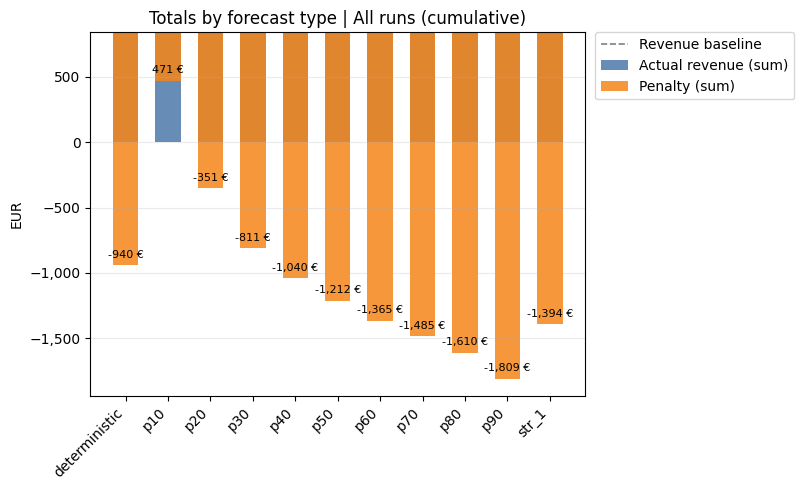

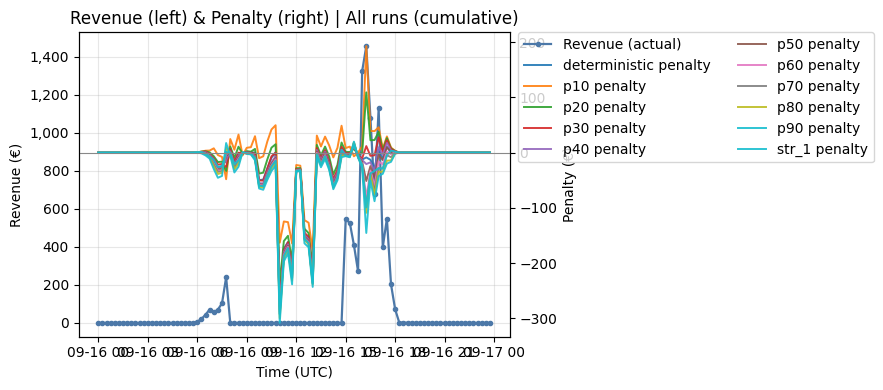

Run forecast_202509151100.csv: deterministic total_net_EUR = -940.18 €, str_1 = -1,394.47 €, Δ = -48.32%


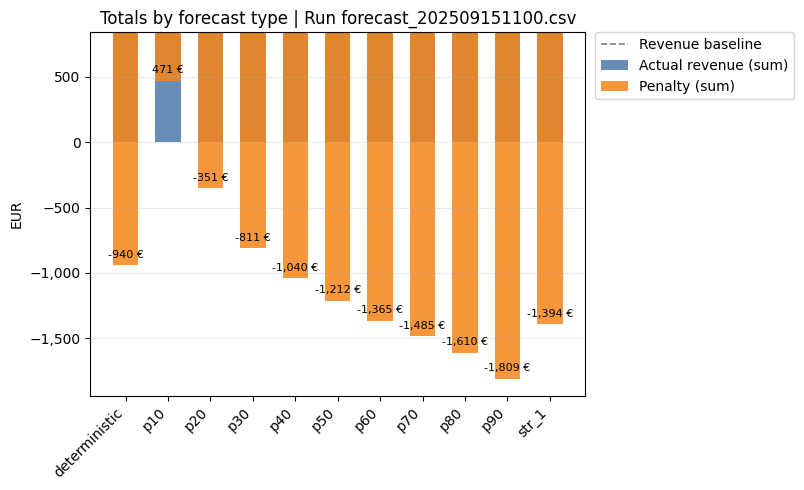

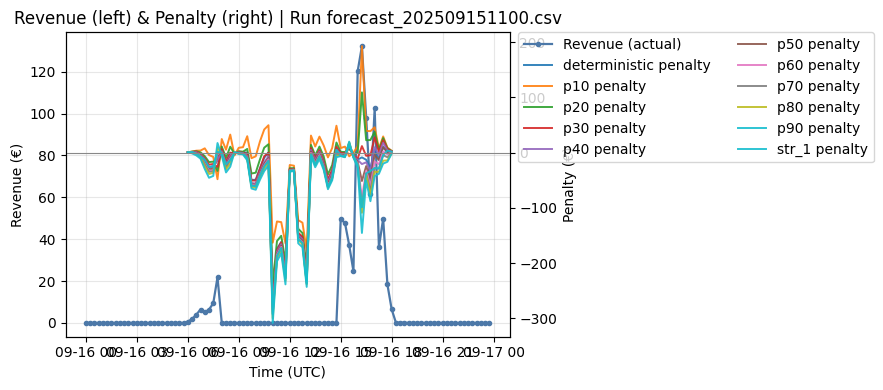

In [8]:
# ---- Graph generation across runs ----
# Adjust these parameters as needed
SELECTED_TYPES = ["deterministic", "p10", "p20", "p30", "p40", "p50", "p60", "p70", "p80", "p90", "str_1"]
START_TS = None   # e.g., "2025-09-07 00:00:00+00:00" or None
END_TS = None     # e.g., "2025-09-08 23:00:00+00:00" or None
RUNS_TO_PLOT = ["ALL"]  # use ["ALL"] for cumulative + every run; otherwise list forecast filenames
MAX_RUNS = None           # set to an integer to limit number of per-run plots

if combined_ledger.empty:
    print("combined_ledger is empty — run the build cell first.")
else:
    unique_runs = sorted(combined_ledger["forecast_file"].unique())

    if RUNS_TO_PLOT is None:
        runs_iter = []
        plot_all = False
    else:
        plot_all = "ALL" in RUNS_TO_PLOT or len(RUNS_TO_PLOT) == 0
        runs_iter = unique_runs if plot_all else [run for run in RUNS_TO_PLOT if run in unique_runs]

    if plot_all:
        plot_ledger_subset(combined_ledger, "All runs (cumulative)", start_ts=START_TS, end_ts=END_TS,
                           selected_types=SELECTED_TYPES, aggregate_runs=True)

    if MAX_RUNS is not None:
        runs_iter = runs_iter[:MAX_RUNS]

    for run_name in runs_iter:
        plot_ledger_subset(combined_ledger[combined_ledger["forecast_file"] == run_name],
                           f"Run {run_name}",
                           start_ts=START_TS,
                           end_ts=END_TS,
                           selected_types=SELECTED_TYPES,
                           aggregate_runs=False)


In [9]:
import matplotlib.ticker as mtick

def _ensure_utc(ts):
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")


def plot_ledger_subset(ledger_subset: pd.DataFrame,
                       label: str,
                       start_ts=None,
                       end_ts=None,
                       selected_types=None,
                       aggregate_runs: bool = True) -> None:
    """Render stacked-bar + time-series plots for a ledger slice."""
    if ledger_subset.empty:
        print(f"{label}: no data available.")
        return

    data = ledger_subset.copy()
    start_ts = _ensure_utc(start_ts)
    end_ts = _ensure_utc(end_ts)
    if start_ts is not None:
        data = data[data["target_time"] >= start_ts]
    if end_ts is not None:
        data = data[data["target_time"] <= end_ts]
    if data.empty:
        print(f"{label}: no rows within the chosen time window.")
        return

    if selected_types:
        selected_types = [ft for ft in selected_types if ft in data["forecast_type"].unique()]
        if not selected_types:
            print(f"{label}: none of the requested forecast types are present.")
            return
        data = data[data["forecast_type"].isin(selected_types)]
    else:
        selected_types = sorted(data["forecast_type"].unique())

    data = data.sort_values(["forecast_type", "target_time"]).reset_index(drop=True)

    # Aggregate totals per forecast type
    agg = (
        data.groupby("forecast_type", as_index=False)
            .agg(
                total_revenue_EUR=("revenue_EUR", "sum"),
                total_penalty_EUR=("penalty_EUR", "sum"),
                total_net_EUR=("net_revenue_EUR", "sum"),
                n_15min=("net_revenue_EUR", "size"),
            )
    )

    # Baseline actual revenue (unique sum across target_time, not duplicated per forecast type)
    rev_unique = (
        data[["target_time", "revenue_EUR"]]
        .drop_duplicates(subset=["target_time"], keep="last")
        .sort_values("target_time")
    )
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if not rev_unique.empty else np.nan

    # Delta vs deterministic for context
    det_net = np.nan
    if "deterministic" in agg["forecast_type"].values:
        det_net = float(agg.loc[agg["forecast_type"] == "deterministic", "total_net_EUR"].iloc[0])
    agg["pct_vs_det"] = np.nan
    if np.isfinite(det_net) and not np.isclose(det_net, 0.0):
        agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / abs(det_net) * 100.0

    if ("str_1" in agg["forecast_type"].values) and np.isfinite(det_net) and det_net != 0:
        str_net = float(agg.loc[agg["forecast_type"] == "str_1", "total_net_EUR"].iloc[0])
        pct = float(agg.loc[agg["forecast_type"] == "str_1", "pct_vs_det"].iloc[0])
        print(f"{label}: deterministic total_net_EUR = {det_net:,.2f} €, str_1 = {str_net:,.2f} €, Δ = {pct:.2f}%")

    # ----- Figure 1: Stacked bars (Revenue + Penalty) with revenue baseline line and label -----
    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(agg))
    width = 0.6

    # Stacked bars
    ax.bar(
        x,
        agg["total_revenue_EUR"].to_numpy(),
        width=width,
        label="Actual revenue (sum)",
        color="#4C78A8",
        alpha=0.85,
    )
    ax.bar(
        x,
        agg["total_penalty_EUR"].to_numpy(),
        width=width,
        bottom=agg["total_revenue_EUR"].to_numpy(),
        label="Penalty (sum)",
        color="#F58518",
        alpha=0.85,
    )

    # Baseline line + non-overlapping label (no markers)
    if np.isfinite(rev_baseline_total):
        ax.axhline(
            rev_baseline_total,
            color="gray",
            linestyle="--",
            linewidth=1.2,
            label="Revenue baseline",
        )
        ax.annotate(
            f"Baseline: {rev_baseline_total:,.0f} €",
            xy=(0.98, rev_baseline_total),
            xycoords=("axes fraction", "data"),
            ha="right",
            va="bottom",
            fontsize=9,
            color="gray",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.65),
            zorder=4,
        )

    # Axis formatting and labels
    ax.set_xticks(x)
    ax.set_xticklabels(agg["forecast_type"], rotation=45, ha="right")
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.set_ylabel("EUR")
    ax.set_title(f"Totals by forecast type | {label}")
    ax.grid(axis="y", alpha=0.25)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

    # Annotate net totals
    net_vals = agg["total_revenue_EUR"].to_numpy() + agg["total_penalty_EUR"].to_numpy()
    for xi, yi in zip(x, net_vals):
        if np.isfinite(yi):
            ax.annotate(
                f"{yi:,.0f} €",
                xy=(xi, yi),
                xycoords="data",
                textcoords="offset points",
                xytext=(0, 4),
                ha="center",
                va="bottom",
                fontsize=7,
            )

    # Autoscale and margins to prevent cramped labels
    ax.margins(y=0.10)
    ax.relim()
    ax.autoscale_view()

    ax.legend()
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    # ----- Figure 2: Time-series: Actual revenue (+ markers) and penalties per forecast type -----
    fig, ax1 = plt.subplots(figsize=(11, 4))
    if aggregate_runs:
        rev_series = data.groupby("target_time", as_index=False)["revenue_EUR"].sum()
    else:
        rev_series = (
            data[["target_time", "revenue_EUR"]]
            .drop_duplicates(subset=["target_time"], keep="last")
            .sort_values("target_time")
        )

    ax1.plot(
        rev_series["target_time"],
        rev_series["revenue_EUR"],
        label="Revenue (actual)",
        color="#4C78A8",
        linewidth=1.6,
        marker="o",
        markersize=3,
    )
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Revenue (€)")
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax1.tick_params(axis="both", labelsize=9)

    ax2 = ax1.twinx()
    cmap = plt.get_cmap("tab10", len(selected_types))
    for idx, ft in enumerate(selected_types):
        if aggregate_runs:
            s = (
                data.loc[data["forecast_type"] == ft]
                .groupby("target_time", as_index=False)["penalty_EUR"]
                .sum()
            )
        else:
            s = (
                data.loc[data["forecast_type"] == ft, ["target_time", "penalty_EUR"]]
                .sort_values("target_time")
            )
        ax2.plot(
            s["target_time"],
            s["penalty_EUR"],
            label=f"{ft} penalty",
            color=cmap(idx),
            linewidth=1.4,
            alpha=0.9,
        )

    # Zero line for penalties (can be +/-)
    ax2.axhline(0, color="#888", linewidth=0.8)

    # Autoscale + margins
    ax1.margins(y=0.10); ax1.relim(); ax1.autoscale_view()
    ax2.margins(y=0.10); ax2.relim(); ax2.autoscale_view()

    # Reduce x tick overlap for dates
    fig.autofmt_xdate(rotation=30)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        ncol=2,
        borderaxespad=0.0,
    )
    ax2.set_ylabel("Penalty (€)")
    plt.title(f"Revenue (left) & Penalty (right) | {label}")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

All runs (cumulative): deterministic total_net_EUR = -940.18 €, str_1 = -1,394.47 €, Δ = -48.32%


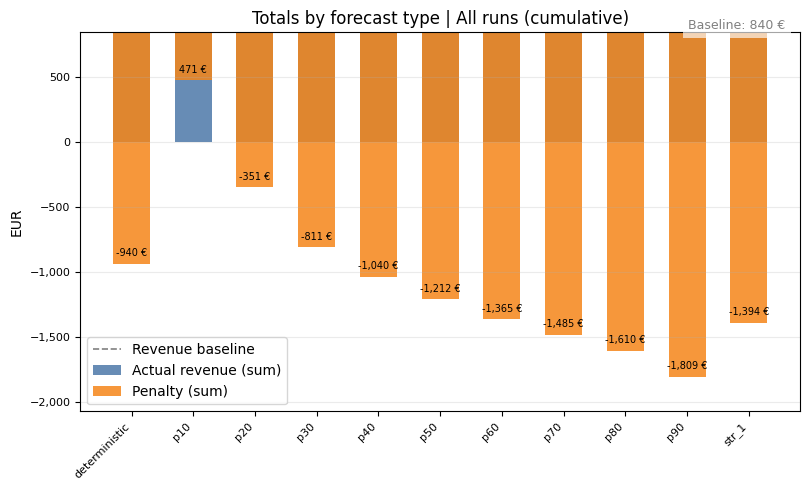

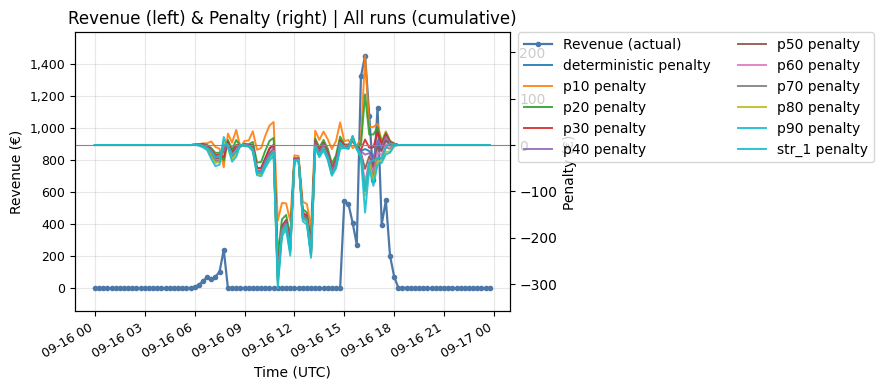

Run forecast_202509151100.csv: deterministic total_net_EUR = -940.18 €, str_1 = -1,394.47 €, Δ = -48.32%


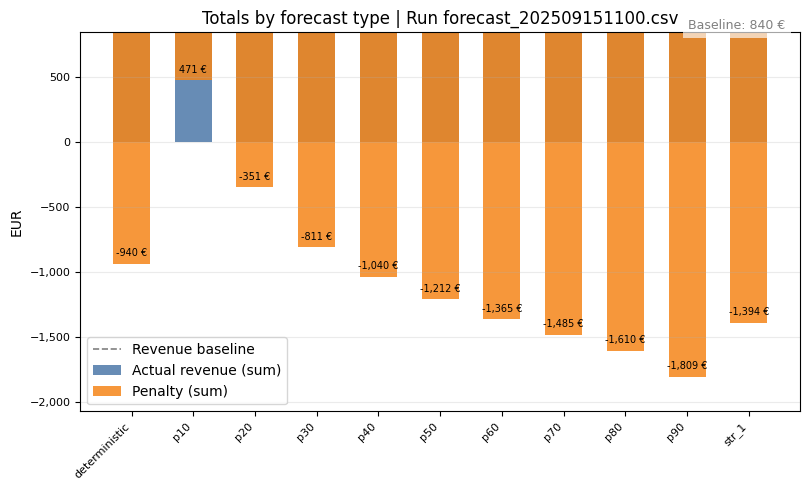

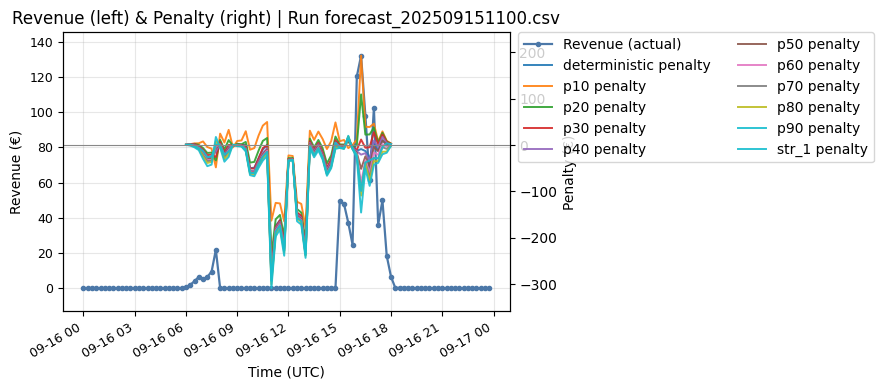

In [10]:
# ---- Graph generation across runs ----
# Adjust these parameters as needed
SELECTED_TYPES = ["deterministic", "p10", "p20", "p30", "p40", "p50", "p60", "p70", "p80", "p90", "str_1"]
START_TS = None   # e.g., "2025-09-07 00:00:00+00:00" or None
END_TS = None     # e.g., "2025-09-08 23:00:00+00:00" or None
RUNS_TO_PLOT = ["ALL"]  # use ["ALL"] for cumulative + every run; otherwise list forecast filenames
MAX_RUNS = None           # set to an integer to limit number of per-run plots

if combined_ledger.empty:
    print("combined_ledger is empty — run the build cell first.")
else:
    unique_runs = sorted(combined_ledger["forecast_file"].unique())

    if RUNS_TO_PLOT is None:
        runs_iter = []
        plot_all = False
    else:
        plot_all = "ALL" in RUNS_TO_PLOT or len(RUNS_TO_PLOT) == 0
        runs_iter = unique_runs if plot_all else [run for run in RUNS_TO_PLOT if run in unique_runs]

    if plot_all:
        plot_ledger_subset(combined_ledger, "All runs (cumulative)", start_ts=START_TS, end_ts=END_TS,
                           selected_types=SELECTED_TYPES, aggregate_runs=True)

    if MAX_RUNS is not None:
        runs_iter = runs_iter[:MAX_RUNS]

    for run_name in runs_iter:
        plot_ledger_subset(combined_ledger[combined_ledger["forecast_file"] == run_name],
                           f"Run {run_name}",
                           start_ts=START_TS,
                           end_ts=END_TS,
                           selected_types=SELECTED_TYPES,
                           aggregate_runs=False)


In [11]:
# Net revenue boxplot across forecast types with outliers and stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_utc(ts):
    if ts is None:
        return None
    ts = pd.to_datetime(ts)
    try:
        # If naive, localize to UTC; if tz-aware, convert to UTC
        if ts.tzinfo is None or ts.tzinfo.utcoffset(ts) is None:
            return ts.tz_localize("UTC")
        return ts.tz_convert("UTC")
    except Exception:
        # Fallback if it's a sequence or something unusual
        return pd.to_datetime(ts, utc=True)

def plot_net_revenue_boxplot(
    df,
    label="",
    start_ts=None,
    end_ts=None,
    include_types=None,
    show_outliers=True,
    figsize=(12, 6),
):
    """
    Box plot of net_revenue_EUR by forecast_type.
    - Shows outliers (toggle with show_outliers)
    - Shows means
    - Annotates μ, σ², n per forecast_type

    Args:
        df: DataFrame with columns ['target_time','forecast_type','net_revenue_EUR', 'revenue_EUR','penalty_EUR']
        label: Optional subtitle text.
        start_ts/end_ts: Optional datetime-like to filter target_time (interpreted/converted to UTC).
        include_types: Optional list of forecast types to include; if None uses all present.
        show_outliers: Whether to plot outliers.
        figsize: Figure size.
    """
    if df is None or len(df) == 0:
        raise ValueError("Input DataFrame is empty. Build or load 'combined_ledger' first.")

    s = df.copy()

    # Ensure target_time exists and filter by time if provided
    if "target_time" not in s.columns:
        raise ValueError("DataFrame must contain a 'target_time' column.")
    s = s[pd.notnull(s["target_time"])]

    st = _ensure_utc(start_ts) if start_ts is not None else None
    et = _ensure_utc(end_ts) if end_ts is not None else None
    if st is not None:
        s = s[s["target_time"] >= st]
    if et is not None:
        s = s[s["target_time"] <= et]

    # Select forecast types
    if include_types is None:
        include_types = (
            s["forecast_type"]
            .dropna()
            .astype(str)
            .sort_values()
            .unique()
            .tolist()
        )
    else:
        include_types = [str(t) for t in include_types]
        
    s = s[s["forecast_type"].astype(str).isin(include_types)]

    # Ensure net_revenue_EUR exists
    if "net_revenue_EUR" not in s.columns:
        if {"revenue_EUR", "penalty_EUR"}.issubset(s.columns):
            s = s.copy()
            s["net_revenue_EUR"] = s["revenue_EUR"] - s["penalty_EUR"]
        else:
            raise ValueError("Missing 'net_revenue_EUR' (or revenue/penalty to compute it).")

    # Build data series per type
    data = [s.loc[s["forecast_type"].astype(str) == t, "net_revenue_EUR"].dropna().values for t in include_types]

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(top=700,bottom=-600)
    bp = ax.boxplot(
        data,
        labels=include_types,
        showmeans=True,
        meanline=False,
        showfliers=show_outliers,
        patch_artist=True,
    )

    # Color boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(include_types))) if len(include_types) > 0 else []
    for patch, c in zip(bp.get("boxes", []), colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.75)

    # Titles/labels
    subtitle = f" | {label}" if label else ""
    # subtitle = f"P30/P70" if label else ""
    ax.set_title(f"Net revenue by forecast type{subtitle}")
    ax.set_ylabel("Net revenue [EUR]")
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    ax.grid(axis="y", linestyle="--", alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # Annotate μ, σ², n right above the top whisker of each box
    whiskers = bp.get("whiskers", [])
    for i, t in enumerate(include_types, start=1):
        vals = s.loc[s["forecast_type"].astype(str) == t, "net_revenue_EUR"].dropna().values
        if vals.size == 0:
            continue
        mu = float(np.mean(vals))
        var = float(np.var(vals, ddof=1)) if vals.size > 1 else 0.0
        n = int(vals.size)
        # Top whisker is the second whisker per box: index 2*(i-1)+1
        if 2 * (i - 1) + 1 < len(whiskers):
            y_top = whiskers[2 * (i - 1) + 1].get_ydata()[1]
        else:
            y_top = np.nanmax(vals)
        ax.text(
            i,
            y_top,
            f"μ={mu:,.0f}\nσ²={var:,.0f}\nn={n}",
            fontsize=9,
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.8),
        )

    fig.tight_layout()
    plt.show()

# Example usage (adjust include_types or time window as needed):
# include_types = sorted(combined_ledger['forecast_type'].astype(str).unique())
# plot_net_revenue_boxplot(
#     combined_ledger,
#     label="All horizons",
#     include_types=include_types,
#     show_outliers=True
# )

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_ledger_subset(
    df,
    label="",
    start_ts=None,
    end_ts=None,
    include_types=None,
    figsize=(16, 6),
):
    """
    Two-panel plot:
    - Left: stacked bars per forecast_type (Revenue + Penalty), dashed baseline showing total unique revenue,
      and net annotations atop each bar. Autoscaled with margins to avoid overlap.
    - Right: time-series of Revenue (unique per target_time) and total Penalty (sum across included types)
      on twin y-axes. Autoscaled and formatted for readability.

    Baseline revenue is computed by summing revenue_EUR after de-duplicating by target_time
    to avoid double-counting across forecast types.

    Args:
        df: DataFrame with columns ['target_time','forecast_type','revenue_EUR','penalty_EUR', ...]
        label: Optional subtitle text.
        start_ts/end_ts: Optional datetime-like to filter target_time (interpreted/converted to UTC).
        include_types: Optional list of forecast types to include; if None uses all present.
        figsize: Figure size.
    """
    if df is None or len(df) == 0:
        raise ValueError("Input DataFrame is empty. Build or load 'combined_ledger' first.")

    s = df.copy()
    if "target_time" not in s.columns:
        raise ValueError("DataFrame must contain a 'target_time' column.")
    s = s[pd.notnull(s["target_time"])]

    def _to_utc(ts):
        if ts is None:
            return None
        ts = pd.to_datetime(ts)
        try:
            if ts.tzinfo is None or ts.tzinfo.utcoffset(ts) is None:
                return ts.tz_localize("UTC")
            return ts.tz_convert("UTC")
        except Exception:
            return pd.to_datetime(ts, utc=True)

    st = _to_utc(start_ts) if start_ts is not None else None
    et = _to_utc(end_ts) if end_ts is not None else None
    if st is not None:
        s = s[s["target_time"] >= st]
    if et is not None:
        s = s[s["target_time"] <= et]

    # Decide types
    if include_types is None:
        include_types = (
            s["forecast_type"]
            .dropna()
            .astype(str)
            .sort_values()
            .unique()
            .tolist()
        )
    else:
        include_types = [str(t) for t in include_types]
    s = s[s["forecast_type"].astype(str).isin(include_types)]

    # Aggregate totals by type
    need_cols = {"revenue_EUR", "penalty_EUR"}
    if not need_cols.issubset(s.columns):
        raise ValueError(f"DataFrame must contain columns: {need_cols}")
    agg = (
        s.groupby(s["forecast_type"].astype(str))
        .agg(revenue_EUR=("revenue_EUR", "sum"), penalty_EUR=("penalty_EUR", "sum"))
        .reindex(include_types)
        .fillna(0.0)
    )

    # Baseline: sum unique revenue per timestamp (avoid double-counting across types)
    rev_unique = (
        s.sort_values("target_time")
         .drop_duplicates(subset="target_time", keep="first")
    )
    rev_baseline_total = float(rev_unique["revenue_EUR"].sum()) if len(rev_unique) else 0.0

    # Time-series penalty: sum across included types per timestamp
    pen_ts = (
        s.groupby("target_time", as_index=False)["penalty_EUR"]
        .sum()
        .sort_values("target_time")
    )

    # Figure with two panels
    fig, (ax0, ax1_left) = plt.subplots(
        1, 2, figsize=figsize, gridspec_kw={"width_ratios": [1.2, 2]}
    )
    ax1_right = ax1_left.twinx()

    # Left: stacked bars + baseline
    x = np.arange(len(include_types))
    rev_vals = agg["revenue_EUR"].values
    pen_vals = agg["penalty_EUR"].values

    ax0.bar(x, rev_vals, label="Revenue", color="tab:blue")
    ax0.bar(x, pen_vals, bottom=rev_vals, label="Penalty", color="tab:red", alpha=0.7)

    # Baseline as dashed line + label (no markers)
    ax0.axhline(rev_baseline_total, linestyle="--", color="black", linewidth=1.0)
    if len(x) > 0:
        ax0.text(
            x[-1] + 0.5,
            rev_baseline_total,
            f"Baseline: {rev_baseline_total:,.0f} €",
            ha="left",
            va="center",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.85),
        )

    ax0.set_xticks(x)
    ax0.set_xticklabels(include_types, rotation=30, ha="right")
    ax0.set_ylabel("EUR")
    subtitle = f" | {label}" if label else ""
    ax0.set_title(f"Totals by forecast type{subtitle}")
    ax0.grid(axis="y", linestyle="--", alpha=0.3)

    # Annotate net per bar (revenue - penalty)
    net_vals = rev_vals - pen_vals
    tops = rev_vals + pen_vals
    for i, (t, n) in enumerate(zip(tops, net_vals)):
        ax0.text(i, t, f"net={n:,.0f}", ha="center", va="bottom", fontsize=9)

    # Autoscale and margins to reduce overlap
    ax0.relim()
    ax0.autoscale_view()
    ax0.margins(y=0.12)
    ax0.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))

    # Right: time-series revenue (unique) and penalty (sum across types)
    if len(rev_unique) > 0:
        ax1_left.plot(
            rev_unique["target_time"],
            rev_unique["revenue_EUR"],
            label="Revenue (unique)",
            color="tab:blue",
        )
    if len(pen_ts) > 0:
        ax1_right.plot(
            pen_ts["target_time"],
            pen_ts["penalty_EUR"],
            label="Penalty (sum)",
            color="tab:red",
            alpha=0.8,
        )

    ax1_left.set_xlabel("Time")
    ax1_left.set_ylabel("Revenue [EUR]", color="tab:blue")
    ax1_right.set_ylabel("Penalty [EUR]", color="tab:red")
    for tl in ax1_left.get_yticklabels():
        tl.set_color("tab:blue")
    for tl in ax1_right.get_yticklabels():
        tl.set_color("tab:red")
    ax1_left.grid(axis="y", linestyle="--", alpha=0.3)

    # Autoscale both y-axes and give a little breathing room
    for ax in (ax1_left, ax1_right):
        ax.relim()
        ax.autoscale_view()
        ax.margins(y=0.12)
    fig.autofmt_xdate()

    # Combined legend for the right panel
    l1, lbl1 = ax1_left.get_legend_handles_labels()
    l2, lbl2 = ax1_right.get_legend_handles_labels()
    if l1 or l2:
        ax1_left.legend(l1 + l2, lbl1 + lbl2, loc="upper left", bbox_to_anchor=(1.02, 1.0))

    fig.tight_layout()
    plt.show()

# Example usage (adjust as needed):
# plot_ledger_subset(
#     combined_ledger,
#     label="Selected range",
#     start_ts=None,  # e.g., "2025-07-07 00:00:00+00:00"
#     end_ts=None,    # e.g., "2025-07-08 00:00:00+00:00"
#     include_types=sorted(combined_ledger['forecast_type'].astype(str).unique()),
# )

In [7]:

# Let's now call the function to plot the boxplot
# We can use the `combined_ledger` DataFrame which should contain all the necessary data
# after running the previous cells.

# Get all unique forecast types to be plotted
include_types = sorted(combined_ledger['forecast_type'].astype(str).unique())

# Generate the box plot
plot_net_revenue_boxplot(
    combined_ledger,
    label="P40 / P70 -> 2025-08-31 to 2025-09-30",
    include_types=include_types,
    show_outliers=True
)


NameError: name 'plot_net_revenue_boxplot' is not defined

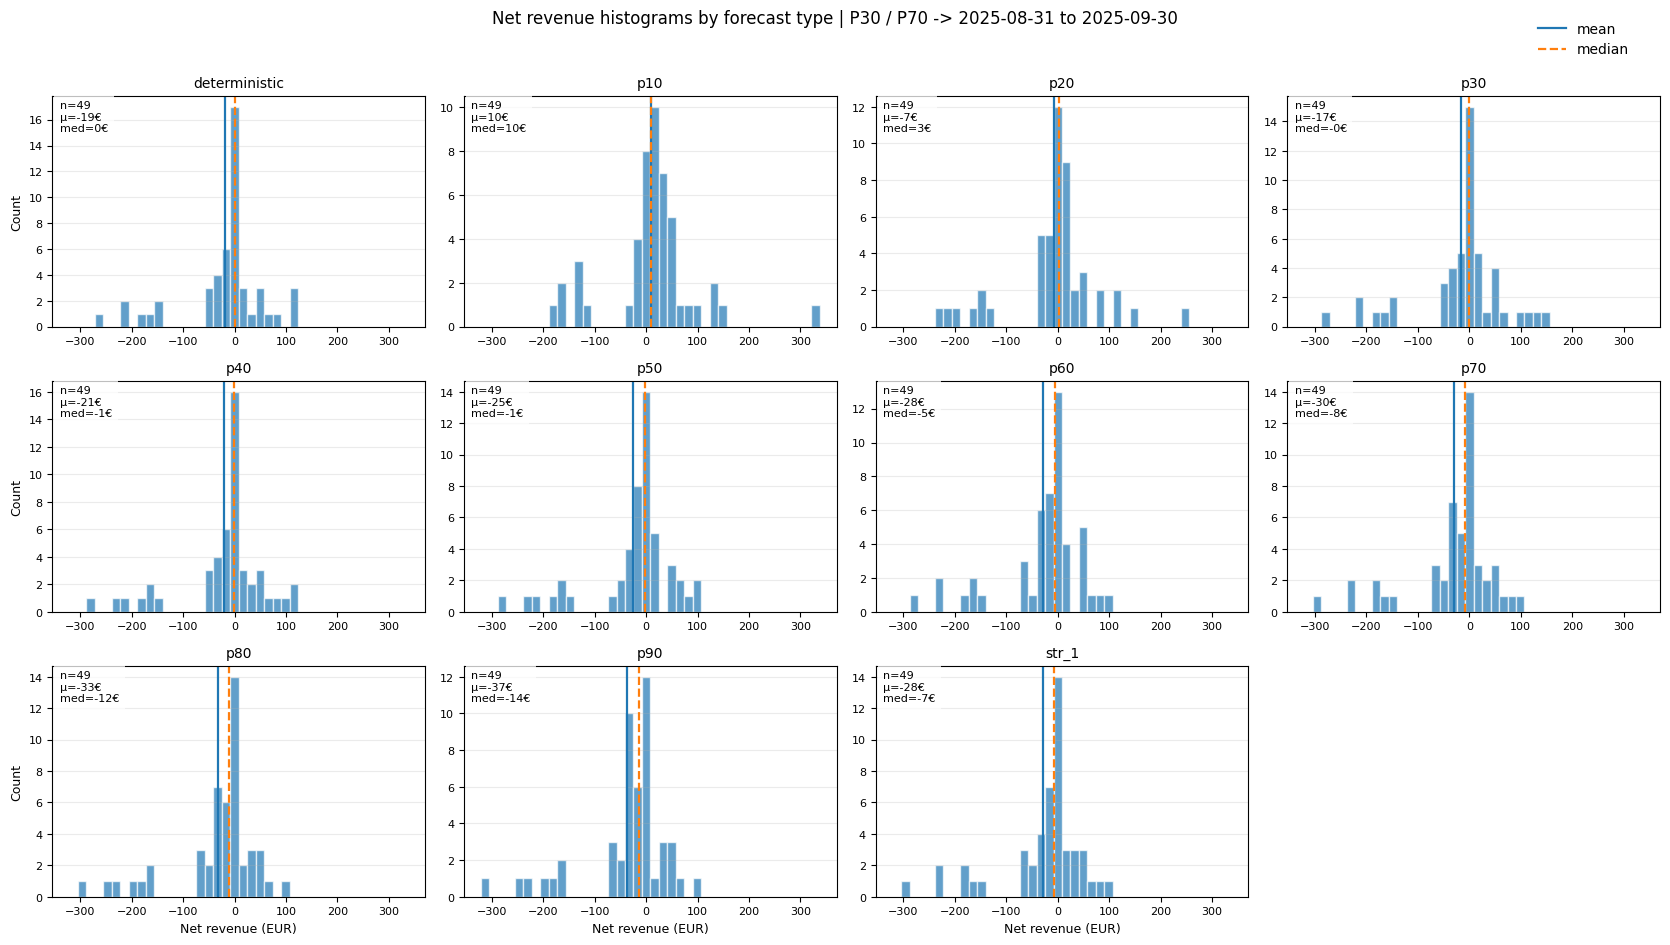

In [ ]:
# Histograms of net revenue by forecast type (same data/filters as Cell 11)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def _ensure_utc(ts):
    if ts is None:
        return None
    ts = pd.to_datetime(ts)
    try:
        if ts.tzinfo is None or ts.tzinfo.utcoffset(ts) is None:
            return ts.tz_localize("UTC")
        else:
            return ts.tz_convert("UTC")
    except Exception:
        return pd.to_datetime(ts, utc=True)

def plot_net_revenue_histograms(
    df: pd.DataFrame,
    label: str = "",
    include_types=None,     # e.g. ["deterministic","p10","p50",...]; if None, use all present
    start_ts=None,
    end_ts=None,
    bins: int = 40,         # number of histogram bins (global across all types)
    density: bool = False,  # set True to show probability density instead of counts
    cols: int = 4           # number of columns for the small-multiples grid
):
    """
    Small-multiples histograms of net_revenue_EUR by forecast_type.
    Uses a shared global set of bins so distributions are directly comparable.
    Shows vertical lines for mean (solid) and median (dashed), plus a small stats box.
    """

    req = ["forecast_type", "net_revenue_EUR", "target_time"]
    if df is None or df.empty or any(c not in df.columns for c in req):
        print("Histogram: input DF missing required columns or is empty.")
        return

    data = df.copy()

    # Time window (same logic as Cell 11)
    st = _ensure_utc(start_ts)
    et = _ensure_utc(end_ts)
    if st is not None:
        data = data[data["target_time"] >= st]
    if et is not None:
        data = data[data["target_time"] <= et]
    if data.empty:
        print("Histogram: no rows after time filtering.")
        return

    # Which forecast types
    if include_types is None or len(include_types) == 0:
        types = sorted(data["forecast_type"].astype(str).unique())
    else:
        avail = set(data["forecast_type"].astype(str).unique())
        types = [t for t in include_types if t in avail]
    if not types:
        print("Histogram: none of the requested forecast types are present.")
        return

    # Build vectors per type
    vectors = []
    for t in types:
        v = (
            data.loc[data["forecast_type"].astype(str) == t, "net_revenue_EUR"]
            .astype(float)
            .dropna()
            .to_numpy()
        )
        if v.size == 0:
            continue
        vectors.append((t, v))

    if not vectors:
        print("Histogram: no values to plot.")
        return

    # Global bins (shared across all types) for fair comparison
    all_vals = np.concatenate([v for _, v in vectors])
    vmin, vmax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    # Expand a touch to avoid bars touching edges
    pad = 0.02 * max(1.0, vmax - vmin)
    bin_edges = np.linspace(vmin - pad, vmax + pad, bins + 1)

    # Grid layout
    n = len(vectors)
    cols = max(1, cols)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows), squeeze=False)
    axes = axes.ravel()

    for ax in axes[n:]:
        ax.axis("off")

    for ax, (t, v) in zip(axes, vectors):
        ax.hist(v, bins=bin_edges, density=density, alpha=0.7, edgecolor="white")
        mu = float(np.mean(v))
        med = float(np.median(v))

        # mean (solid) and median (dashed)
        ax.axvline(mu, color="tab:blue", linewidth=1.6, label="mean")
        ax.axvline(med, color="tab:orange", linewidth=1.6, linestyle="--", label="median")

        # compact stats box (won't overlap the bars much; anchored to axes coords)
        ax.text(
            0.02, 0.98,
            f"n={len(v)}\nμ={mu:,.0f}€\nmed={med:,.0f}€",
            transform=ax.transAxes,
            va="top", ha="left",
            fontsize=8,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.75)
        )

        ax.set_title(t, fontsize=10)
        ax.grid(axis="y", alpha=0.25)
        ax.tick_params(labelsize=8)

    # Shared labels
    fig.suptitle(f"Net revenue histograms by forecast type | {label}", y=0.98, fontsize=12)
    mid_row = max(0, rows - 1)
    for c in range(cols):
        axes[mid_row*cols + c].set_xlabel("Net revenue (EUR)", fontsize=9)
    for r in range(rows):
        axes[r*cols + 0].set_ylabel("Density" if density else "Count", fontsize=9)

    # One combined legend (mean/median) outside the grid
    handles = [
        plt.Line2D([0], [0], color="tab:blue", lw=1.6, label="mean"),
        plt.Line2D([0], [0], color="tab:orange", lw=1.6, ls="--", label="median"),
    ]
    fig.legend(handles=handles, loc="upper right", bbox_to_anchor=(0.98, 0.98), frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Example usage (mirrors Cell 13's include_types & label) ---
include_types = sorted(combined_ledger['forecast_type'].astype(str).unique())
plot_net_revenue_histograms(
combined_ledger,
label="P30 / P70 -> 2025-08-31 to 2025-09-30",
include_types=include_types,
start_ts=None,
end_ts=None,
bins=40,
density=False,
cols=4
)


/tmp/ipykernel_7230/1390669959.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=include_types, showmeans=True, showfliers=show_outliers, patch_artist=True)


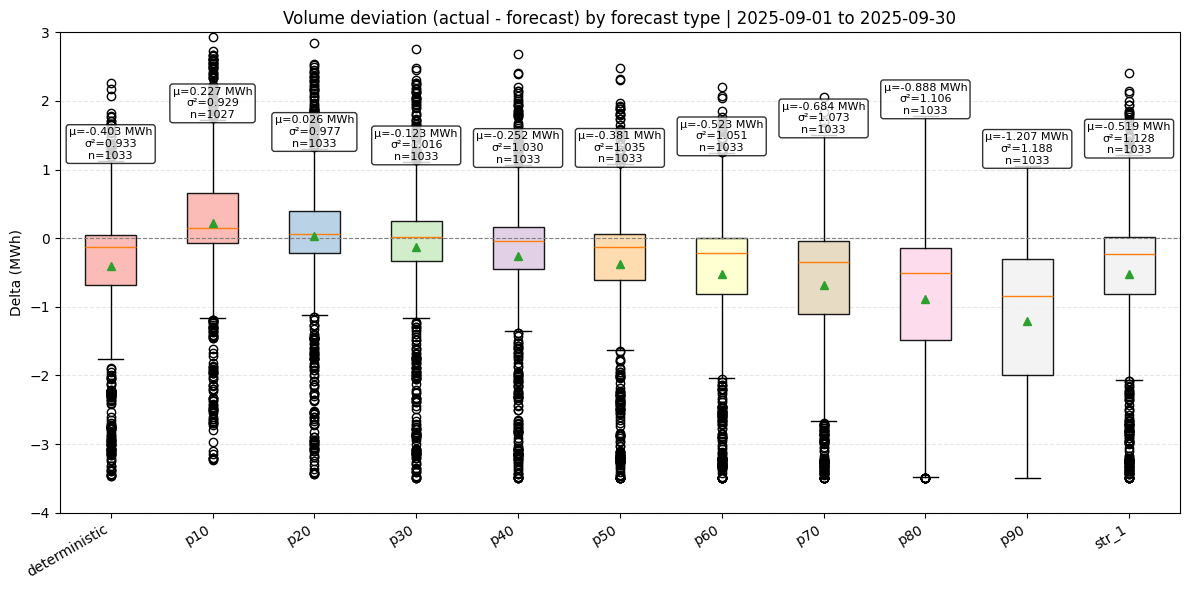

In [23]:
# Plot boxplots of volume deviations (delta_MWh) by forecast type (all quantiles + strategy)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_volume_deviation_boxplot(
    df,
    label="",
    start_ts=None,
    end_ts=None,
    include_types=None,
    show_outliers=True,
    figsize=(12, 6),
):
    """
    Box plot of volume deviations (delta_MWh) by forecast_type.
    - Uses 'delta_MWh' if present; otherwise computes actual_MWh - forecast_MWh.
    - Annotates mean (μ), sample variance (σ²) and count (n) for each type.

    Args:
        df: DataFrame containing 'target_time', 'forecast_type' and either 'delta_MWh' or
            both 'actual_MWh' and 'forecast_MWh'.
        label: optional subtitle text shown in the title.
        start_ts/end_ts: optional time window (strings or pd.Timestamp).
        include_types: list of forecast_type strings to include (defaults to all present).
        show_outliers: whether to display fliers on the boxes.
        figsize: tuple for figure size.
    """

    if df is None or df.empty:
        raise ValueError("Input DataFrame is empty. Build/load 'combined_ledger' first.")

    s = df.copy()
    if 'target_time' not in s.columns:
        raise ValueError("DataFrame must contain a 'target_time' column.")
    s = s[pd.notnull(s['target_time'])].copy()

    # Normalize and apply time window if provided (preserve tz-awareness where possible)
    def _to_ts(t):
        if t is None:
            return None
        tt = pd.to_datetime(t)
        try:
            if tt.tzinfo is None or tt.tzinfo.utcoffset(tt) is None:
                return tt.tz_localize('UTC')
            return tt.tz_convert('UTC')
        except Exception:
            return pd.to_datetime(tt, utc=True)

    st = _to_ts(start_ts)
    et = _to_ts(end_ts)
    if st is not None:
        s = s[s['target_time'] >= st]
    if et is not None:
        s = s[s['target_time'] <= et]
    if s.empty:
        raise ValueError('No rows after time filtering.')

    # Select forecast types
    if include_types is None:
        include_types = s['forecast_type'].dropna().astype(str).sort_values().unique().tolist()
    else:
        include_types = [str(t) for t in include_types]
    s = s[s['forecast_type'].astype(str).isin(include_types)]
    if s.empty:
        raise ValueError('No matching forecast types present in the data.')

    # Ensure delta_MWh exists or compute it
    if 'delta_MWh' not in s.columns:
        if {'actual_MWh', 'forecast_MWh'}.issubset(s.columns):
            s['delta_MWh'] = s['actual_MWh'] - s['forecast_MWh']
        else:
            raise ValueError("Missing 'delta_MWh' (or actual_MWh/forecast_MWh to compute it).")

    # Build list of arrays for boxplot (preserve ordering of include_types)
    data = [s.loc[s['forecast_type'].astype(str) == t, 'delta_MWh'].dropna().values for t in include_types]

    # Draw boxplot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylim(top=3,bottom=-4)

    bp = ax.boxplot(data, labels=include_types, showmeans=True, showfliers=show_outliers, patch_artist=True)

    # Color boxes for readability
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(include_types))) if len(include_types) > 0 else []
    for patch, c in zip(bp.get('boxes', []), colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)

    # Title, labels and grid
    subtitle = f" | {label}" if label else ""
    ax.set_title(f"Volume deviation (actual - forecast) by forecast type{subtitle}")
    ax.set_ylabel('Delta (MWh)')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # Annotate mean, variance and n for each box just above the upper whisker
    whiskers = bp.get('whiskers', [])
    for i, t in enumerate(include_types, start=1):
        vals = s.loc[s['forecast_type'].astype(str) == t, 'delta_MWh'].dropna().values
        if vals.size == 0:
            continue
        mu = float(np.mean(vals))
        var = float(np.var(vals, ddof=1)) if vals.size > 1 else 0.0
        n = int(vals.size)
        # Prefer whisker top if available; otherwise use max value
        if 2 * (i - 1) + 1 < len(whiskers):
            y_top = whiskers[2 * (i - 1) + 1].get_ydata()[1]
        else:
            y_top = np.nanmax(vals)
        ax.text(i, y_top, f"μ={mu:.3f} MWh\nσ²={var:.3f}\nn={n}",
                fontsize=8, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8))

    # Zero reference line helps show bias direction
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    fig.tight_layout()
    plt.show()

# Example call: plot all quantiles + strategy 'str_1' present in combined_ledger
include_types = sorted(combined_ledger['forecast_type'].astype(str).unique())
plot_volume_deviation_boxplot(
    combined_ledger,
    label="2025-09-01 to 2025-09-30",
    include_types=include_types,
    show_outliers=True,
)
